In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

### Source Code Citation: 
https://www.kaggle.com/code/asilpoyrazahin/tusimple-lane-detection

In [4]:
### Loading the dataset

In [5]:
#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm as notebook_tqdm
import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image

import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1

from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings("ignore")


### Dataset Information

#### Dataset Size
3626 video clips, 3626 labelled frames. 
Information of each clip: 20 frames for each one.

#### Directory Structure:
   		|
   		|----readme.md  				# description
   		|
   		|----clips/ 					# video clips, 3626 clips
   		|------|
   		|------|----0313-1/60/1.jpg	# Sequential images for the clip, Each folder within 0313-1/# holds 20 frames
   		|------|----...
   		|
   		|----label_data_0313.json			# Label data for lanes
   		|----label_data_0531.json			# Label data for lanes
   		|----label_data_0601.json			# Label data for lanes

In [6]:
### Code to assert a specific folder related to 

IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [7]:
### Function to create directories within the dataset folder:

def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [8]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [9]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder to simplify training or dataset access.
"""
#-----------------------------------------------------------------------------------------
"""
Due to the dataset structure of the training set (dataset\lanes\TUSimple\train_set\clips\0313-1\#), 
First, we grab the image and mask associated with the 20th frame from each of the 3,626 folders in the train_set directory.
Then, we take that 20th image/mask, and store them in the IMAGE_FOLDER and MASK_FOLDER folder we created previously.
The purpose of this is because the dataset labels.json files are only for the 20th frame of each of the training clips. 
## Label Data Format
Each json line in 'label_data.json' is the label data for __the last (20th) frame__ of this clip.

"""
#-----------------------------------------------------------------------------------------

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [10]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [11]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

"""
For the ease of use of the one JSON file, we combine the json file into one dataframe for ease of use. 
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
print("""
{
  'raw_file': str. Clip file path.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])

    1.Each lane is a list of x-coordinates (width values in the image).
    2. The corresponding h_samples are the y-coordinates (height values in the image).
    3. Pairing lanes[i][j] with h_samples[j] gives you the pixel (x, y) of the lane marking on the image.
    4. So effectively, the dataset is describing polylines (lane centerlines/edges) in image coordinates.
}
""")
df_json.head()


{
  'raw_file': str. Clip file path.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])

    1.Each lane is a list of x-coordinates (width values in the image).
    2. The corresponding h_samples are the y-coordinates (height values in the image).
    3. Pairing lanes[i][j] with h_samples[j] gives you the pixel (x, y) of the lane marking on the image.
    4. So effectively, the dataset is describing polylines (lane centerlines/edges) in image coordinates.
}



lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

### Creating the Masks
    1. What is a mask?
    Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
    2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [12]:
# create function for generating masks
"""
1. Creates an empty black mask image (728x1280).
2. Extracts lane info (lanes, h_samples) and the raw file path.
3. For each lane: Removes invalid points (-2).
5. Pairs valid (x, y) coordinates into lane points.
6. Draws a white polyline (thickness 15 px) on the mask.
7. Builds an output filename from the raw file path (e.g., 0313-1_5160.jpg).
8. Saves the mask image to the MASK FOLDER Previously created.
"""
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [13]:
# generate masks
from tqdm import tqdm  #   Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:09<00:00, 381.31it/s]


In [14]:

"""
Builds file paths for the road image (IMAGE_FOLDER) and its corresponding mask (MASK_FOLDER).

Reads the road image and converts it from BGR (OpenCV default) to RGB (for correct colors).

Reads the mask image.

Creates a Matplotlib figure with two subplots side by side.

Left subplot: shows the road image with the title "Road Image".

Right subplot: shows the mask in grayscale with the title "Ground Truth Mask".

Displays both images together for visual comparison.
"""
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

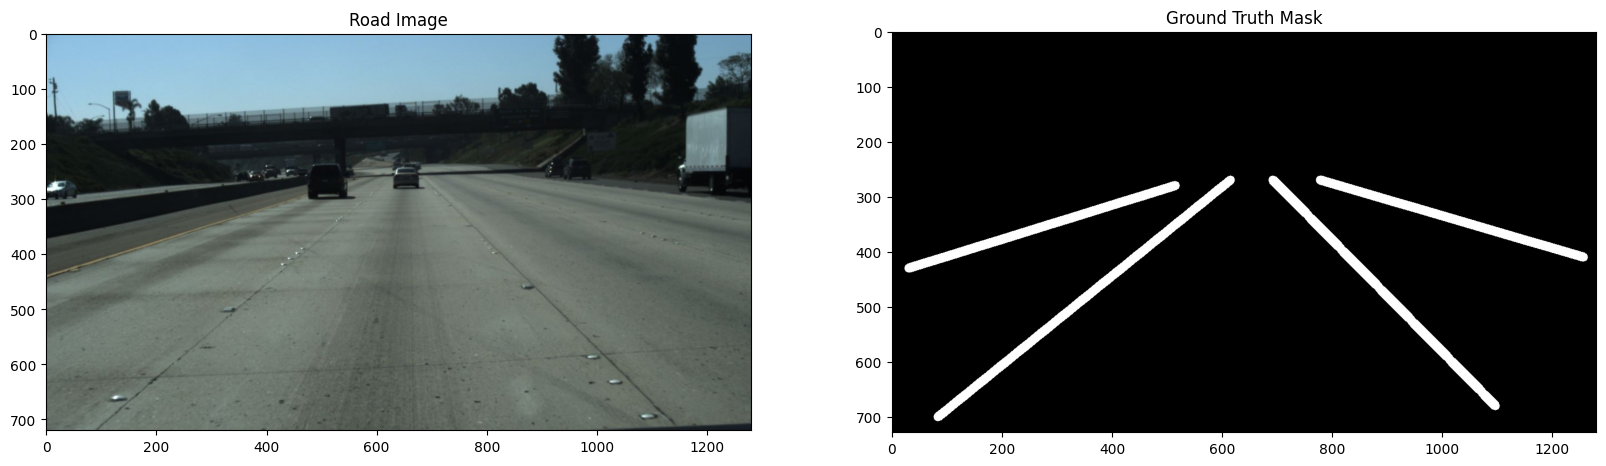

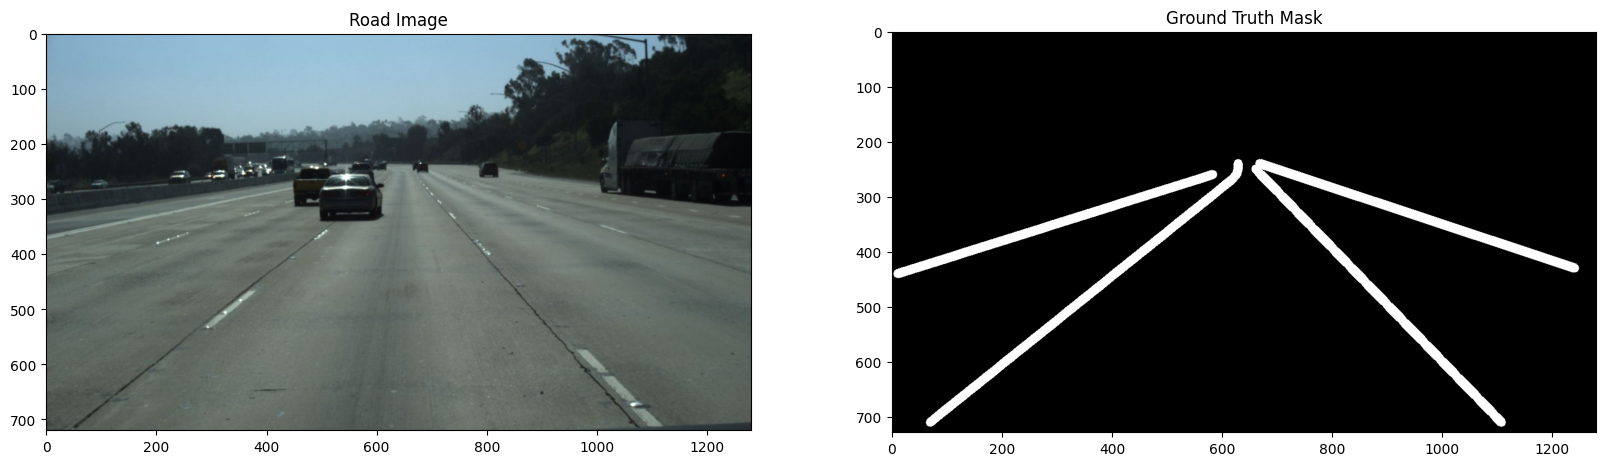

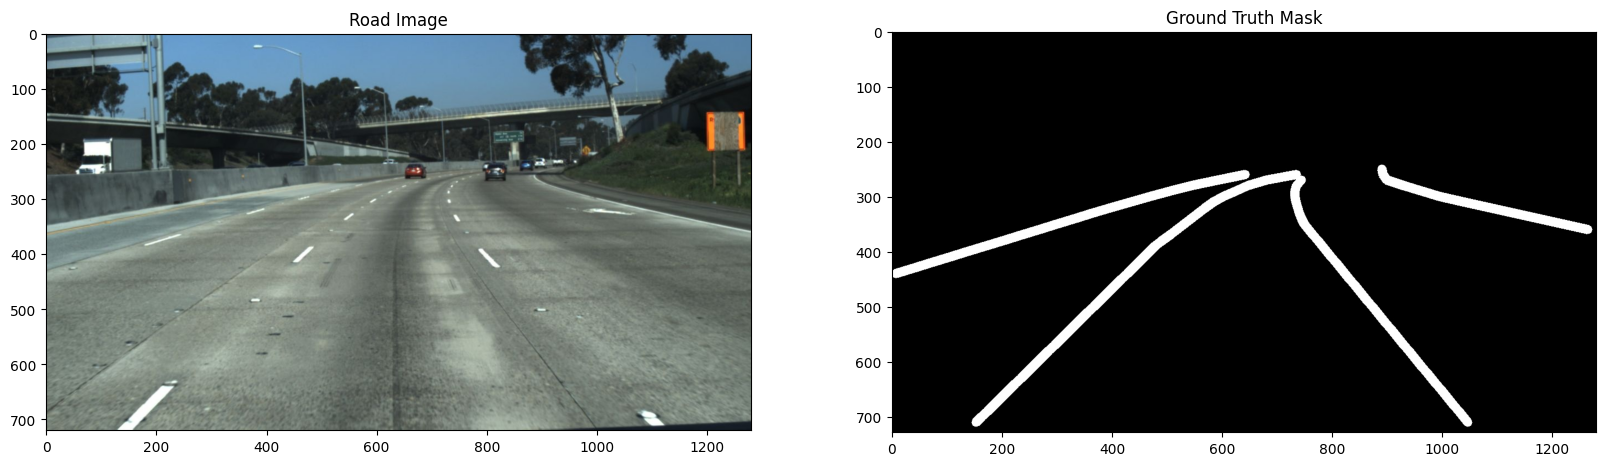

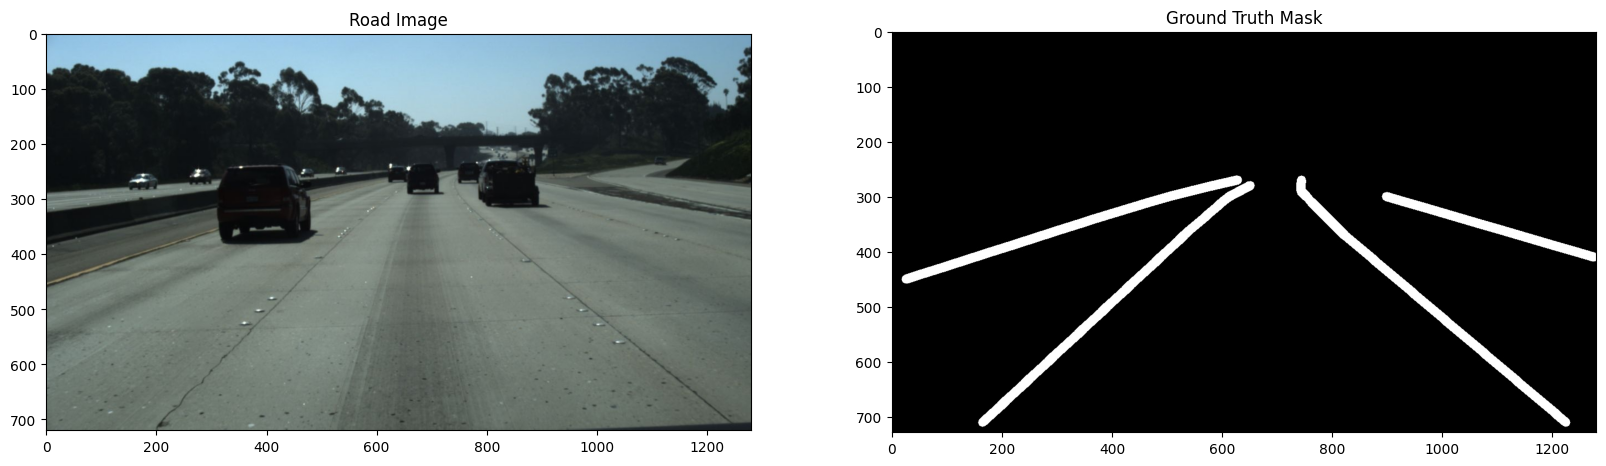

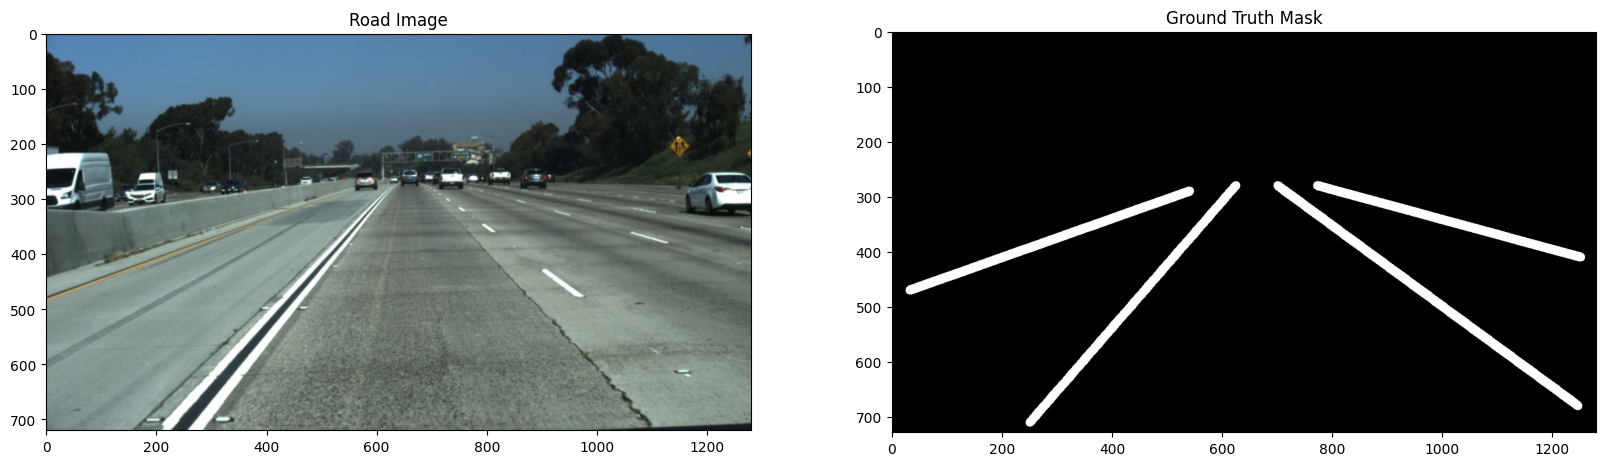

In [15]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

In [16]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


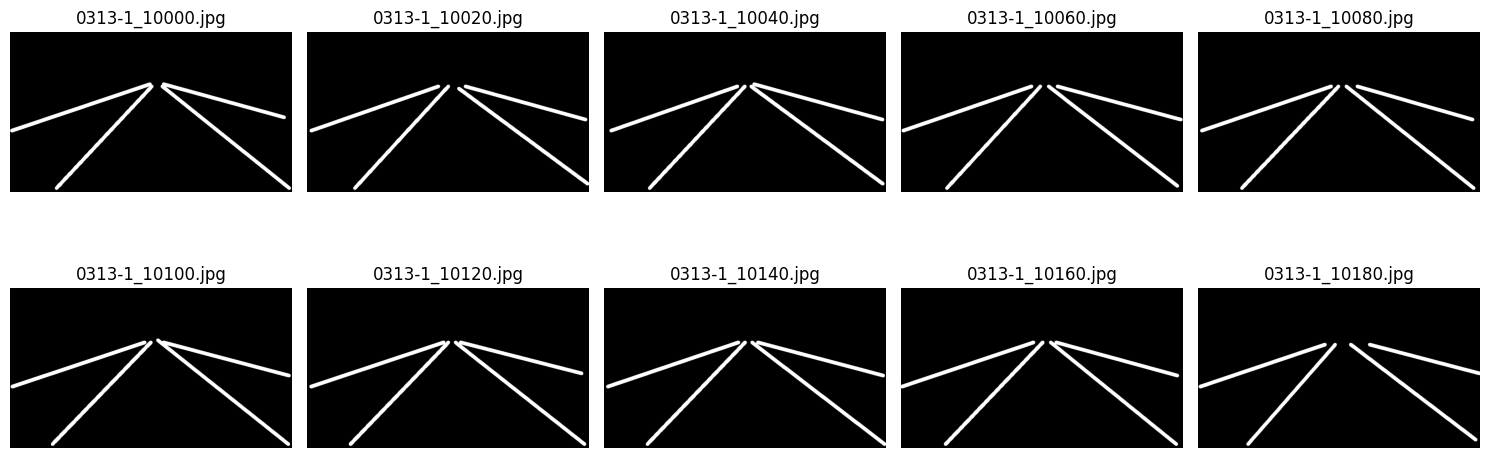

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

# List all mask image files (sorted for consistency)
mask_files = sorted([
    f for f in os.listdir(MASK_FOLDER) if f.endswith(('.png', '.jpg'))
])[:10]

# Plot the first 10 masks
plt.figure(figsize=(15, 6))

for i, mask_file in enumerate(mask_files):
    mask_path = os.path.join(MASK_FOLDER, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Training and Validation Splits and Processing
    1. Images
    2. Masks 

In [18]:
# Creating new directories to grab from IMAGE_FOLDER and MASK_FOLDER

lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_val_image_folder = r"Z:\EE_297A\dataset\lanes\val\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_val_mask_folder = r"Z:\EE_297A\dataset\lanes\val\masks"

In [19]:
for folder_path in [lane_train_image_folder, lane_val_image_folder, lane_train_mask_folder, lane_val_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\val\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\val\masks


In [20]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for training and validation
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### UNUSED CODE

### MODEL CREATION

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

"""
Main: Lightweight semantic segmentation model for lane detection
    built on MobileNetV2 as the encoder and a simple upsampling decoder

    Model Components:
1. Encoder (Feature Extractor)
    Uses MobileNetV2 from torchvision.models.
    Pretrained on ImageNet if pretrained=True.
    Extracts features up to the final convolution block (m.features).

2. Decoder (Segmentation Head)
    No skip connections (unlike U-Net) → lightweight and faster, but less spatial detail.
    Sequence of ConvTranspose2d (upsampling by 2) + Conv2d blocks.
    After each upsample, features are refined with Conv → BN → ReLU.
        Channel progression: 1280 → 256 → 128 → 64 → 32 → 1
    Spatial resolution progression (starting from 7×7): → 14 → 28 → 56 → 112
    Final output before interpolation: (B, 1, 112, 112) logits.
    
"""

class LaneSegOnlyMobileNetV2(nn.Module):
    def __init__(self, pretrained=True, freeze_stem=False):
        super().__init__()
        # ---- Encoder: MobileNetV2 ----
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.mobilenet_v2(weights=weights)

        # Feature extractor (ends at last conv-bn-relu block)
        self.encoder = m.features              # output: (B, 1280, 7, 7) for 224x224
        enc_out_ch = 1280

        if freeze_stem:
            # freeze early, cheap speed/regularization trick
            for p in list(self.encoder.parameters())[:]:
                p.requires_grad = False

        # ---- Lightweight decoder (no skip connections) ----
        self.seg_head = nn.Sequential(
            nn.ConvTranspose2d(enc_out_ch, 256, kernel_size=2, stride=2),  # 7 -> 14
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),         # 14 -> 28
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),          # 28 -> 56
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),           # 56 -> 112
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            # Software design only upsamples to 112x112 (Half) becuase of easier hardware implementation.  
            # to get back to the full start resolution in the interpolation
            nn.Conv2d(32, 1, kernel_size=1),  # logits (B,1,112,112)
        )

    def forward(self, x):
        #Stores original height and width.
        H, W = x.shape[-2:]
        
        #Pass input x through MobileNetV2 encoder.
            #Output: compressed, high-level features.
        feats = self.encoder(x)                 # (B,1280,7,7) at 224x224

        #Output: compressed, high-level features.
            #Produces logits for one segmentation class (lane vs background).
        seg   = self.seg_head(feats)           # (B,1,112,112)
        
        """
        This upsamples the segmentation logits from (B,1,112,112) to match the **original input size (H, W)** (e.g., (B,1,224,224)` if input was 224×224).
        Interpolation is basically a resizing operation where
        Bilinear smoothly blend neighboring pixels to get a smoother mask.
        So here, interpolation = “resize the predicted mask to the original image resolution.”
        """
        seg   = F.interpolate(seg, size=(H, W), mode="bilinear", align_corners=False)
        #Returns per-pixel logits
        return seg


In [22]:
#model = LaneSegOnly().to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneSegOnlyMobileNetV2(pretrained=True).to(device)

#output_seg = model(torch.randn(4, 3, 224, 224)).to(device)  # batch of 4
#print(output_seg.shape)  # -> (4, 1, 360, 640)

In [23]:
import os
import cv2
import torch
from torch.utils.data import Dataset

import os
import cv2
import torch
from torch.utils.data import Dataset

"""
Defines a custom PyTorch Dataset for the TuSimple lane segmentation dataset.

Inputs:
images_dir → folder with RGB road images.
masks_dir → folder with binary lane masks.
file_list → list of filenames to load.
transform (optional) → Albumentations-style augmentations.
include_class (optional) → if True, also returns a dummy class label.


__getitem__:
Loads an image and converts it from BGR → RGB.
Loads the corresponding mask in grayscale.
Resizes both to 224×224 (image with bilinear interpolation, mask with nearest neighbor).
Applies augmentations if provided (on both image & mask).
Binarizes mask to values {0,1}.
Converts:
Image → PyTorch tensor (3, H, W) normalized to [0,1].
Mask → PyTorch tensor (1, H, W) of floats.

Returns:
(image_tensor, mask_tensor) normally.
(image_tensor, dummy_class, mask_tensor) if include_class=True.
"""


class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None, include_class=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.include_class = include_class  # if True, returns (img, 0, mask)

        # Ensure file_list is a list of strings
        self.file_list = [f if isinstance(f, str) else f.item() for f in file_list]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        if isinstance(fname, torch.Tensor):
            fname = fname.tolist()

        # --- Load image ---
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load mask ---
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Resize to model output (224x224)
        img  = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)       # image
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST) # 224, 224

        # --- Apply transforms (Albumentations-style) ---
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Binarize after transforms to get {0,1} as float
        mask = (mask > 127).astype("float32")

        # --- Convert to tensors ---
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0   # (3, H, W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()             # (1, H, W)

        if self.include_class:
            dummy_class = torch.tensor(0, dtype=torch.long)
            return img_tensor, dummy_class, mask_tensor
        else:
            return img_tensor, mask_tensor

In [24]:
class SimpleLaneTransform:
    def __init__(self, crop_scale=(0.8, 1.0), output_size=(224, 224)):
        self.crop_scale = crop_scale  # (min, max) relative crop size
        self.output_size = output_size

    def __call__(self, image, mask):
        h, w = image.shape[:2]

        # ───────────── Random Horizontal Flip ─────────────
        if random.random() > 0.5:
            image = cv2.flip(image, 1)
            mask  = cv2.flip(mask, 1)

        # ───────────── Random Small Rotation ─────────────
        if random.random() > 0.5:
            angle = random.uniform(-5, 5)
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
            image = cv2.warpAffine(image, M, (w, h),
                                   flags=cv2.INTER_LINEAR,
                                   borderMode=cv2.BORDER_REFLECT_101)
            mask  = cv2.warpAffine(mask,  M, (w, h),
                                   flags=cv2.INTER_NEAREST,
                                   borderMode=cv2.BORDER_REFLECT_101)

        # ───────────── Random Crop + Resize ─────────────
        if random.random() > 0.5:
            scale = random.uniform(*self.crop_scale)
            new_h, new_w = int(h * scale), int(w * scale)
            top  = random.randint(0, h - new_h)
            left = random.randint(0, w - new_w)
            image = image[top:top+new_h, left:left+new_w]
            mask  = mask[top:top+new_h, left:left+new_w]

            # resize back to original (or fixed) size
            image = cv2.resize(image, self.output_size, interpolation=cv2.INTER_LINEAR)
            mask  = cv2.resize(mask,  self.output_size, interpolation=cv2.INTER_NEAREST)
        else:
            # always resize at the end for consistency
            image = cv2.resize(image, self.output_size, interpolation=cv2.INTER_LINEAR)
            mask  = cv2.resize(mask,  self.output_size, interpolation=cv2.INTER_NEAREST)

        # ───────────── Random Brightness/Contrast ─────────────
        if random.random() > 0.5:
            alpha = 1.0 + 0.2 * (random.random() - 0.5)  # contrast (0.9–1.1)
            beta  = 10 * (random.random() - 0.5)         # brightness (-5 to +5)
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

        # ───────────── Random Gaussian Blur ─────────────
        if random.random() > 0.5:
            k = random.choice([3, 5])  # kernel size
            image = cv2.GaussianBlur(image, (k, k), 0)

        # ───────────── Random Gaussian Noise ─────────────
        if random.random() > 0.5:
            noise = np.random.normal(0, 10, image.shape).astype(np.float32)
            noisy = image.astype(np.float32) + noise
            image = np.clip(noisy, 0, 255).astype(np.uint8)

        # ───────────── Return Dict ─────────────
        return {"image": image, "mask": mask}

In [25]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_val_image_folder   # Z:\...\test\images
val_masks_dir    = lane_val_mask_folder

In [26]:
# Instantiate datasets
train_transform = SimpleLaneTransform()

lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images, transform=train_transform)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

In [27]:
from torch.utils.data import DataLoader
"""
Batch Size: Split the dataset into mini-batches of images + masks.
Batch size = 16: Each training step feeds 16 images + 16 masks through the model

Gen Rule of Thumb: Smaller batch size → noisier updates, but less memory, can help generalization\
                    Larger batch size → smoother updates, faster on GPU, but needs more memory.
"""


lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)


In [28]:
# Print Python version
import sys
sys.version

'3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]'

In [29]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [30]:
# Check GPU availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [31]:
if cuda_available:
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Number of CUDA devices:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"\n[GPU {i}]")
        print("Device Name:", torch.cuda.get_device_name(i))
        print("Device Capability:", torch.cuda.get_device_capability(i))
        print("Total Memory (MB):", round(torch.cuda.get_device_properties(i).total_memory / 1024**2, 2))
        print("Allocated Memory (MB):", round(torch.cuda.memory_allocated(i) / 1024**2, 2))
        print("Cached Memory (MB):", round(torch.cuda.memory_reserved(i) / 1024**2, 2))
else:
    print(" No CUDA-compatible GPU detected.")

CUDA version (PyTorch built with): 12.1
cuDNN version: 90100
Number of CUDA devices: 1

[GPU 0]
Device Name: NVIDIA GeForce RTX 3060 Ti
Device Capability: (8, 6)
Total Memory (MB): 8191.38
Allocated Memory (MB): 17.36
Cached Memory (MB): 28.0


In [32]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training Model: Only Rerun When ready

### OLD Training LOOP: Only Rerun When ready

### Training Model: Only Rerun When ready


Epoch 1/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:02<00:00,  3.25it/s]


Train Loss: 1.3885


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.78it/s]


Val Loss: 1.3111

Epoch 2/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.46it/s]


Train Loss: 1.2751


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 1.2334

Epoch 3/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 1.2110


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Val Loss: 1.1772

Epoch 4/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 1.1432


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 1.1238

Epoch 5/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 1.0806


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 1.0491

Epoch 6/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 1.0288


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.9966

Epoch 7/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.9786


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.9492

Epoch 8/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.9346


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.9095

Epoch 9/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.8938


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.8730

Epoch 10/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:00<00:00,  3.39it/s]


Train Loss: 0.8527


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.71it/s]


Val Loss: 0.8231

Epoch 11/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.46it/s]


Train Loss: 0.8125


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.52it/s]


Val Loss: 0.7798

Epoch 12/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.51it/s]


Train Loss: 0.7742


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.89it/s]


Val Loss: 0.7447

Epoch 13/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.56it/s]


Train Loss: 0.7383


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.99it/s]


Val Loss: 0.7037

Epoch 14/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.7030


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Val Loss: 0.6672

Epoch 15/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.54it/s]


Train Loss: 0.6691


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.6491

Epoch 16/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.6401


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.6166

Epoch 17/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.6141


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.95it/s]


Val Loss: 0.5798

Epoch 18/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.5855


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.5751

Epoch 19/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.56it/s]


Train Loss: 0.5630


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.11it/s]


Val Loss: 0.5292

Epoch 20/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.52it/s]


Train Loss: 0.5422


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.66it/s]


Val Loss: 0.5146

Epoch 21/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.50it/s]


Train Loss: 0.5204


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.85it/s]


Val Loss: 0.5008

Epoch 22/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.50it/s]


Train Loss: 0.5045


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.81it/s]


Val Loss: 0.4745

Epoch 23/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.50it/s]


Train Loss: 0.4887


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.87it/s]


Val Loss: 0.4640

Epoch 24/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:59<00:00,  3.44it/s]


Train Loss: 0.4716


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.03it/s]


Val Loss: 0.4439

Epoch 25/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.4595


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.4311

Epoch 26/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.4468


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.91it/s]


Val Loss: 0.4250

Epoch 27/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.4340


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.00it/s]


Val Loss: 0.4171

Epoch 28/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.4263


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


Val Loss: 0.4081

Epoch 29/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.4178


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3938

Epoch 30/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.4079


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


Val Loss: 0.3839

Epoch 31/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.58it/s]


Train Loss: 0.3993


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3918

Epoch 32/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.3936


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.84it/s]


Val Loss: 0.3783

Epoch 33/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.3889


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3745

Epoch 34/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.3869


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.84it/s]


Val Loss: 0.3599

Epoch 35/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.54it/s]


Train Loss: 0.3770


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3732

Epoch 36/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.3736


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.51it/s]


Val Loss: 0.3530

Epoch 37/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.3687


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3684

Epoch 38/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.3621


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.3476

Epoch 39/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.3607


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.3563

Epoch 40/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.69it/s]


Train Loss: 0.3569


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3411

Epoch 41/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.58it/s]


Train Loss: 0.3521


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.3403

Epoch 42/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:59<00:00,  3.46it/s]


Train Loss: 0.3516


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.3490

Epoch 43/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:59<00:00,  3.43it/s]


Train Loss: 0.3484


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3375

Epoch 44/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.3440


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.3338

Epoch 45/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.3397


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3430

Epoch 46/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.3394


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.3236

Epoch 47/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.3382


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.3282

Epoch 48/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.3352


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.79it/s]


Val Loss: 0.3231

Epoch 49/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.76it/s]


Train Loss: 0.3332


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.3266

Epoch 50/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:52<00:00,  3.86it/s]


Train Loss: 0.3319


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.31it/s]


Val Loss: 0.3391

Epoch 51/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.74it/s]


Train Loss: 0.3272


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.28it/s]


Val Loss: 0.3224

Epoch 52/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.75it/s]


Train Loss: 0.3301


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.56it/s]


Val Loss: 0.3291

Epoch 53/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.75it/s]


Train Loss: 0.3237


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.96it/s]


Val Loss: 0.3214

Epoch 54/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.71it/s]


Train Loss: 0.3213


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.67it/s]


Val Loss: 0.3210

Epoch 55/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.75it/s]


Train Loss: 0.3220


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.71it/s]


Val Loss: 0.3219

Epoch 56/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.74it/s]


Train Loss: 0.3198


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.61it/s]


Val Loss: 0.3174

Epoch 57/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.71it/s]


Train Loss: 0.3198


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.56it/s]


Val Loss: 0.3328

Epoch 58/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.3180


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.3154

Epoch 59/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.51it/s]


Train Loss: 0.3158


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3198

Epoch 60/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.3160


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3148

Epoch 61/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.3143


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.55it/s]


Val Loss: 0.3154

Epoch 62/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:53<00:00,  3.82it/s]


Train Loss: 0.3102


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.17it/s]


Val Loss: 0.3133

Epoch 63/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.76it/s]


Train Loss: 0.3113


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.28it/s]


Val Loss: 0.3293

Epoch 64/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.68it/s]


Train Loss: 0.3086


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Val Loss: 0.3295

Epoch 65/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.3106


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3104

Epoch 66/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.3107


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.78it/s]


Val Loss: 0.3313

Epoch 67/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.3061


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3128

Epoch 68/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.3025


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.3155

Epoch 69/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.76it/s]


Train Loss: 0.3045


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.3157

Epoch 70/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.69it/s]


Train Loss: 0.3038


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.01it/s]


Val Loss: 0.3235

Epoch 71/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.53it/s]


Train Loss: 0.3009


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.87it/s]


Val Loss: 0.3142

Epoch 72/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.3036


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.3236

Epoch 73/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2992


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.3218

Epoch 74/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2985


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3157

Epoch 75/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2967


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.15it/s]


Val Loss: 0.3181

Epoch 76/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2947


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.85it/s]


Val Loss: 0.3264

Epoch 77/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.71it/s]


Train Loss: 0.2961


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.87it/s]


Val Loss: 0.3092

Epoch 78/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.2954


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.3124

Epoch 79/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:54<00:00,  3.75it/s]


Train Loss: 0.2911


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.76it/s]


Val Loss: 0.3211

Epoch 80/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.2892


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.3121

Epoch 81/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2900


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3106

Epoch 82/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.58it/s]


Train Loss: 0.2946


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.3076

Epoch 83/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.2907


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.3282

Epoch 84/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.51it/s]


Train Loss: 0.2910


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.10it/s]


Val Loss: 0.3198

Epoch 85/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.56it/s]


Train Loss: 0.2900


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3089

Epoch 86/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2859


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.3098

Epoch 87/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.70it/s]


Train Loss: 0.2865


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3156

Epoch 88/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.2886


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.3137

Epoch 89/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2878


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.16it/s]


Val Loss: 0.3130

Epoch 90/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.54it/s]


Train Loss: 0.2846


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.85it/s]


Val Loss: 0.3105

Epoch 91/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2849


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3196

Epoch 92/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2841


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.3022

Epoch 93/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2822


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.3138

Epoch 94/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.52it/s]


Train Loss: 0.2825


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.64it/s]


Val Loss: 0.3084

Epoch 95/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2797


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.3042

Epoch 96/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.2795


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3166

Epoch 97/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2815


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.51it/s]


Val Loss: 0.3067

Epoch 98/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.52it/s]


Train Loss: 0.2812


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.60it/s]


Val Loss: 0.3154

Epoch 99/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.48it/s]


Train Loss: 0.2809


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3123

Epoch 100/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2786


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.06it/s]


Val Loss: 0.3123

Epoch 101/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.46it/s]


Train Loss: 0.2755


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3225

Epoch 102/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.56it/s]


Train Loss: 0.2748


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3111

Epoch 103/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2756


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3105

Epoch 104/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2745


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.3218

Epoch 105/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2760


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.3137

Epoch 106/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.54it/s]


Train Loss: 0.2747


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.3102

Epoch 107/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2745


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.43it/s]


Val Loss: 0.3055

Epoch 108/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2731


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.3108

Epoch 109/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2713


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3073

Epoch 110/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2709


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.3043

Epoch 111/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2720


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Val Loss: 0.3107

Epoch 112/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.68it/s]


Train Loss: 0.2700


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Val Loss: 0.3099

Epoch 113/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2715


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3051

Epoch 114/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2687


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.3116

Epoch 115/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2713


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.3236

Epoch 116/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2656


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Val Loss: 0.3107

Epoch 117/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2666


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.39it/s]


Val Loss: 0.3124

Epoch 118/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2699


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3082

Epoch 119/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2646


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.3150

Epoch 120/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2676


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.3208

Epoch 121/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2648


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.47it/s]


Val Loss: 0.3030

Epoch 122/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.2632


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.48it/s]


Val Loss: 0.3136

Epoch 123/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.67it/s]


Train Loss: 0.2645


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.3110

Epoch 124/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2611


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Val Loss: 0.3164

Epoch 125/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2626


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3100

Epoch 126/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2632


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.3039

Epoch 127/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.48it/s]


Train Loss: 0.2648


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.91it/s]


Val Loss: 0.3200

Epoch 128/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.46it/s]


Train Loss: 0.2625


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.05it/s]


Val Loss: 0.3121

Epoch 129/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:58<00:00,  3.46it/s]


Train Loss: 0.2611


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.85it/s]


Val Loss: 0.3165

Epoch 130/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:02<00:00,  3.24it/s]


Train Loss: 0.2631


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  3.85it/s]


Val Loss: 0.3167

Epoch 131/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:06<00:00,  3.07it/s]


Train Loss: 0.2601


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.04it/s]


Val Loss: 0.3122

Epoch 132/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2593


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.45it/s]


Val Loss: 0.3175

Epoch 133/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2581


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.3098

Epoch 134/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2574


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.3132

Epoch 135/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2617


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.3081

Epoch 136/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2560


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3062

Epoch 137/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.64it/s]


Train Loss: 0.2604


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3130

Epoch 138/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2570


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3084

Epoch 139/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2554


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.12it/s]


Val Loss: 0.3084

Epoch 140/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2551


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.3063

Epoch 141/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2528


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3192

Epoch 142/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2526


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.3103

Epoch 143/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2544


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3132

Epoch 144/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2540


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.45it/s]


Val Loss: 0.3145

Epoch 145/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2521


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.3172

Epoch 146/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2509


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.3151

Epoch 147/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.64it/s]


Train Loss: 0.2548


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3114

Epoch 148/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2516


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.3193

Epoch 149/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2485


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3077

Epoch 150/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2511


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3292

Epoch 151/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2498


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3111

Epoch 152/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2504


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.39it/s]


Val Loss: 0.3319

Epoch 153/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2495


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.19it/s]


Val Loss: 0.3171

Epoch 154/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2471


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.46it/s]


Val Loss: 0.3125

Epoch 155/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2481


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.3127

Epoch 156/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2477


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3114

Epoch 157/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2455


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3123

Epoch 158/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2478


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.48it/s]


Val Loss: 0.3133

Epoch 159/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2475


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3128

Epoch 160/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2462


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.3091

Epoch 161/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2462


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.3220

Epoch 162/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2483


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.3103

Epoch 163/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2455


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.3184

Epoch 164/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2476


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3164

Epoch 165/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2430


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3123

Epoch 166/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2451


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.3077

Epoch 167/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2446


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3089

Epoch 168/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2444


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3100

Epoch 169/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2440


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Val Loss: 0.3204

Epoch 170/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2419


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3173

Epoch 171/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2421


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.3230

Epoch 172/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2424


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3135

Epoch 173/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2378


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Val Loss: 0.3126

Epoch 174/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2411


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.13it/s]


Val Loss: 0.3174

Epoch 175/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.68it/s]


Train Loss: 0.2409


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3160

Epoch 176/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2419


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.3185

Epoch 177/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2415


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3097

Epoch 178/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2403


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


Val Loss: 0.3190

Epoch 179/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2394


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.3120

Epoch 180/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2384


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3158

Epoch 181/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.57it/s]


Train Loss: 0.2409


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3289

Epoch 182/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2388


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.3238

Epoch 183/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2394


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.23it/s]


Val Loss: 0.3146

Epoch 184/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.55it/s]


Train Loss: 0.2399


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.44it/s]


Val Loss: 0.3102

Epoch 185/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2360


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.3165

Epoch 186/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2366


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3125

Epoch 187/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2369


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3175

Epoch 188/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2365


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3086

Epoch 189/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2357


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3124

Epoch 190/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2361


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.3191

Epoch 191/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:57<00:00,  3.56it/s]


Train Loss: 0.2371


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3169

Epoch 192/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2350


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3153

Epoch 193/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2344


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3138

Epoch 194/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2364


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3091

Epoch 195/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2353


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.3107

Epoch 196/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.68it/s]


Train Loss: 0.2333


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.47it/s]


Val Loss: 0.3117

Epoch 197/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2334


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.3146

Epoch 198/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2347


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3126

Epoch 199/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2330


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.29it/s]


Val Loss: 0.3171

Epoch 200/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2337


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3162

Epoch 201/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2330


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.21it/s]


Val Loss: 0.3132

Epoch 202/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2314


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.3162

Epoch 203/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2318


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3374

Epoch 204/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2320


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3174

Epoch 205/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.64it/s]


Train Loss: 0.2324


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3180

Epoch 206/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2308


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3120

Epoch 207/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2318


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3163

Epoch 208/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2300


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.26it/s]


Val Loss: 0.3147

Epoch 209/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2278


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.18it/s]


Val Loss: 0.3144

Epoch 210/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2301


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.3123

Epoch 211/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.68it/s]


Train Loss: 0.2305


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3162

Epoch 212/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2288


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.28it/s]


Val Loss: 0.3114

Epoch 213/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.65it/s]


Train Loss: 0.2304


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.3191

Epoch 214/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2298


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3215

Epoch 215/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2289


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.3136

Epoch 216/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2292


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.33it/s]


Val Loss: 0.3139

Epoch 217/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.61it/s]


Train Loss: 0.2300


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.02it/s]


Val Loss: 0.3233

Epoch 218/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:55<00:00,  3.66it/s]


Train Loss: 0.2284


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.36it/s]


Val Loss: 0.3223

Epoch 219/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2301


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.39it/s]


Val Loss: 0.3220

Epoch 220/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2279


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.06it/s]


Val Loss: 0.3180

Epoch 221/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.59it/s]


Train Loss: 0.2278


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.24it/s]


Val Loss: 0.3285

Epoch 222/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.60it/s]


Train Loss: 0.2284


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.27it/s]


Val Loss: 0.3229

Epoch 223/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.58it/s]


Train Loss: 0.2276


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.3250

Epoch 224/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.63it/s]


Train Loss: 0.2240


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.3176

Epoch 225/225


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:56<00:00,  3.62it/s]


Train Loss: 0.2252


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.3196


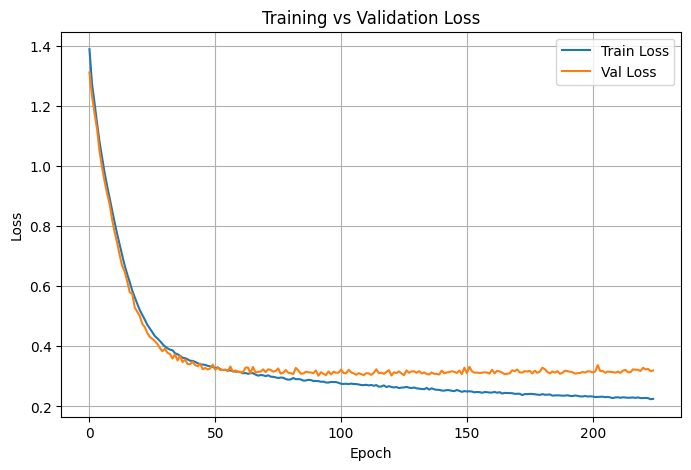

In [33]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Moves the model to GPU if available, otherwise runs on CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function = BCE + Dice
def dice_loss(pred, target, eps=1e-7):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum(dim=(1,2,3))
    den = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
    return 1 - (num / den).mean()

class BCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
    def forward(self, logits, targets):
        return self.bce(logits, targets) + dice_loss(logits, targets)

criterion_seg = BCEDiceLoss()

# Loss function = Binary Cross-Entropy with logits
#criterion_seg = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GradScaler: does mixed precision training (saves memory, speeds up training).
scaler = torch.amp.GradScaler(device.type)

# cudnn.benchmark = True: lets PyTorch pick the fastest algorithm for your GPU.
torch.backends.cudnn.benchmark = True

EPOCHS = 225

# Track losses per epoch
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for images, masks in tqdm(lane_train_loader, desc="Train", leave=True):
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True).float()

    #for batch_idx, (images, masks) in enumerate(tqdm(lane_train_loader, desc="Train", leave=True)):
        #images = images.to(device, non_blocking=True)
        #masks  = masks.to(device, non_blocking=True).float()
        
        optimizer.zero_grad(set_to_none=True)

         #############################################################################################
        """
        1. Reset gradients.
        2. Run the model forward pass → predict segmentation logits.
        3. If the predicted mask size doesn’t match the ground-truth mask, resize it (interpolation).
        4. Compute loss = how wrong the predictions are compared to ground truth.
        """
        #############################################################################################
        with torch.amp.autocast(device.type):   
            out_seg = model(images)
            if out_seg.shape[-2:] != masks.shape[-2:]:
                out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = criterion_seg(out_seg, masks)
        ################################################################################################
       
        # loss.backward() computes gradients of all weights
        scaler.scale(loss).backward()
        
        # Debug: check encoder grads
        #if epoch == 0 and batch_idx == 0:  # first batch only
            #for name, param in list(model.encoder.named_parameters())[:3]:
                #print(f"{name} grad mean:", 
                      #param.grad.mean().item() if param.grad is not None else None)
        
        # optimizer.step() updates the weights.
        scaler.step(optimizer)
        scaler.update()
        
        # Train Loss: The error the model makes on the training set during the current epoch
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(lane_train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(lane_val_loader, desc="Val", leave=True):
            images = images.to(device, non_blocking=True)
            masks  = masks.to(device, non_blocking=True).float()

            with torch.amp.autocast(device.type):
                out_seg = model(images)
                if out_seg.shape[-2:] != masks.shape[-2:]:
                    out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion_seg(out_seg, masks)
            
            # The error the model makes on the validation set (data it has never see
            # Validation loss ↓ = model is learning general patterns (not memorizing).
            val_loss += loss.item()

    avg_val_loss = val_loss / len(lane_val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)

# ---------------- PLOT LOSSES ----------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Loss Function (segmentation only) ===
# Since lane segmentation is binary (lane vs background), we use Binary Cross Entropy (BCE)
# Model outputs raw numbers (logits).ss

criterion_seg = nn.BCEWithLogitsLoss()

# === Metric: Dice Coefficient ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    # y_pred: raw logits -> sigmoid -> threshold -> {0,1}
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean()

# === Test Loop (segmentation only) ===
train_dice_loss = 0.0 # test_loss
train_dice_total = 0.0 # dice_total

model.eval()

with torch.no_grad():
    for batch in tqdm(lane_train_loader):
        # Support both (images, masks)
        # Load images and ground-truth masks from the test loader.
        if len(batch) == 3:
            images, _, masks = batch
        else:
            images, masks = batch

        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()  # BCEWithLogitsLoss expects float

        # Run images through your segmentation model.
        out_seg = model(images)  # LaneSegOnly returns logits for the mask

        # Compare predictions to ground truth masks using BCEWithLogits.
        loss = criterion_seg(out_seg, masks)
        train_dice_loss += loss.item()

        dice = dice_coefficient(masks, out_seg)
        train_dice_total += dice.item()

avg_train_loss = train_dice_loss / len(lane_train_loader)
avg_train_dice_score = train_dice_total / len(lane_train_loader)

print("\ Train Results:")
print(f"Train Dice  Loss: {avg_train_loss:.4f}")
print(f"Train Dice Score: {avg_train_dice_score:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:52<00:00,  3.90it/s]

\ Train Results:
Train Dice  Loss: 0.0452
Train Dice Score: 0.8389


In [35]:
# === Save model weights ===
torch.save(model.state_dict(), "lane_seg_weights_ep225_lr5en5_wd1en4_transGuas_bceDiceLoss.pth")
print(" Model weights saved to lane_seg_weights_ep225_lr5en5_wd1en4_transGuas_bceDiceLoss.pth")

 Model weights saved to lane_seg_weights_ep225_lr5en5_wd1en4_transGuas_bceDiceLoss.pth


### Loading Pretrained Model

In [36]:
model = LaneSegOnlyMobileNetV2()
model.load_state_dict(torch.load("lane_seg_weights_ep225_lr5en5_wd1en4_transGuas_bceDiceLoss.pth"))
model.to(device)
model.eval()  # set to inference mode

C:\Users\Baron\AppData\Local\Temp\ipykernel_10688\3356253605.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_seg_weights_ep225_lr5

LaneSegOnlyMobileNetV2(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2

In [37]:
# Define test folders (if not already defined)

In [38]:
test_images_dir = lane_val_image_folder
test_masks_dir  = lane_val_mask_folder

# Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# Create the dataset
lane_test_dataset = TuSimpleSegDataset(test_images_dir, test_masks_dir, test_images)

#   Wrap in DataLoader
from torch.utils.data import DataLoader

lane_test_loader = DataLoader(lane_test_dataset, batch_size=16, shuffle=False)

In [39]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Loss Function (segmentation only) ===
# Since lane segmentation is binary (lane vs background), we use Binary Cross Entropy (BCE)
# Model outputs raw numbers (logits).ss


# Loss function = BCE + Dice
def dice_loss(pred, target, eps=1e-7):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum(dim=(1,2,3))
    den = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + eps
    return 1 - (num / den).mean()

class BCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
    def forward(self, logits, targets):
        return self.bce(logits, targets) + dice_loss(logits, targets)

criterion_seg = BCEDiceLoss()
#criterion_seg = nn.BCEWithLogitsLoss()

# === Metric: Dice Coefficient ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    # y_pred: raw logits -> sigmoid -> threshold -> {0,1}
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean()

# === Test Loop (segmentation only) ===
test_loss = 0.0
dice_total = 0.0

model.eval()

with torch.no_grad():
    for batch in tqdm(lane_test_loader):
        # Support both (images, masks)
        # Load images and ground-truth masks from the test loader.
        if len(batch) == 3:
            images, _, masks = batch
        else:
            images, masks = batch

        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()  # BCEWithLogitsLoss expects float

        # Run images through your segmentation model.
        out_seg = model(images)  # LaneSegOnly returns logits for the mask

        # Compare predictions to ground truth masks using BCEWithLogits.
        loss = criterion_seg(out_seg, masks)
        test_loss += loss.item()

        dice = dice_coefficient(masks, out_seg)
        dice_total += dice.item()

avg_test_loss = test_loss / len(lane_test_loader)
avg_dice_score = dice_total / len(lane_test_loader)

print("\ Test Results:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Dice Score: {avg_dice_score:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:11<00:00,  1.94it/s]

\ Test Results:
Test Loss: 0.3200
Dice Score: 0.7710


In [40]:
import matplotlib.pyplot as plt
import torch

def show_sample_prediction(model, dataset, device, index=0):
    model.eval()

    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # if dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # if dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # Convert to probabilities
        pred_mask = (pred_mask > 0.5).float()     # Threshold at 0.5

    # --- Convert to numpy for visualization ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (C,H,W) → (H,W,C)
    true_np = true_mask.squeeze().cpu().numpy()
    pred_np = pred_mask.squeeze().cpu().numpy()

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    titles = ["Input Image", "Ground Truth Mask", "Predicted Mask"]
    for i, img in enumerate([img_np, true_np, pred_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


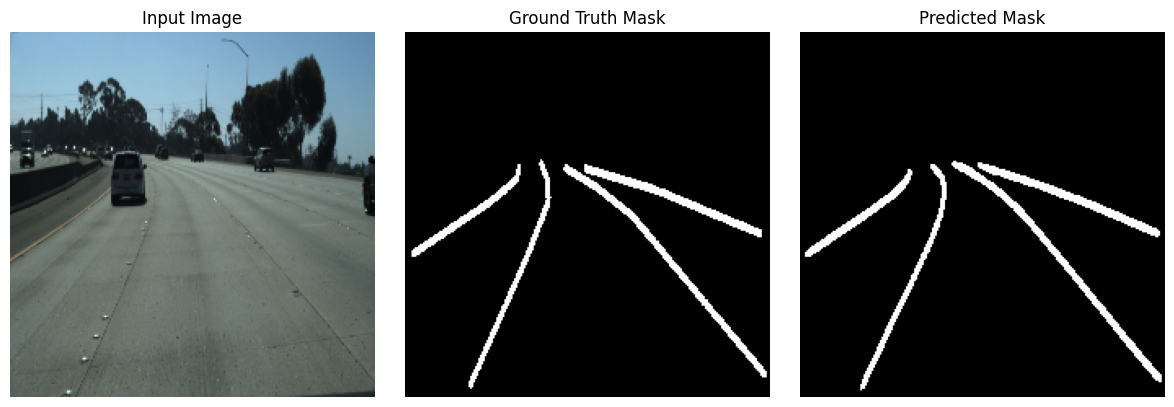

In [41]:
# Example: show first test image prediction
show_sample_prediction(model, lane_test_dataset, device, index=20)

In [42]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

def show_sample_prediction_overlay(model, dataset, device, index=0, alpha=0.4, color=(1, 0, 0)):
    model.eval()
    
    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # → probabilities
        pred_mask = (pred_mask > 0.5).float()     # → binary mask

    # --- Convert tensors to numpy ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    pred_np = pred_mask.squeeze().cpu().numpy()    # (H', W')

    # 🔧 Resize pred mask to match original image size
    pred_np = cv2.resize(pred_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0, 1] for display
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    # --- Create color overlay ---
    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # --- Apply overlay to predicted mask regions ---
    blended = img_np.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


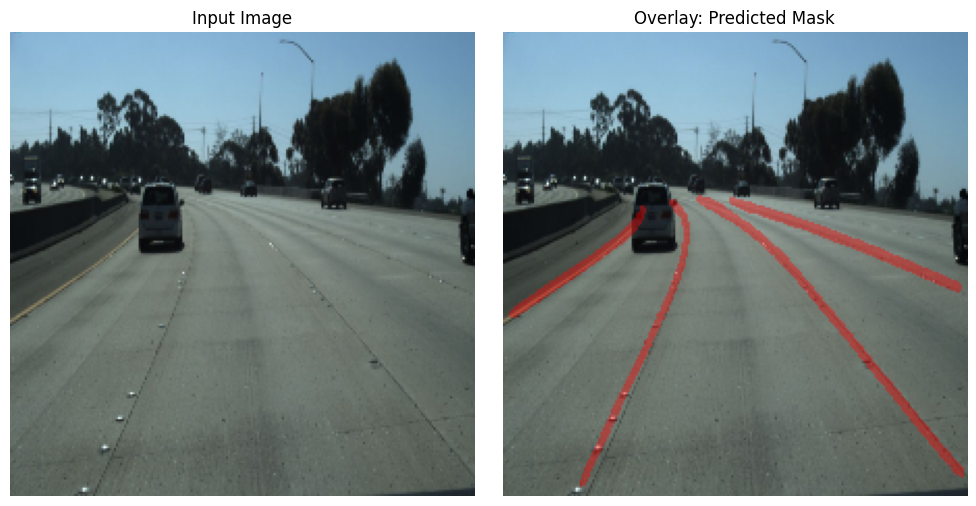

In [43]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=20, alpha=0.4)

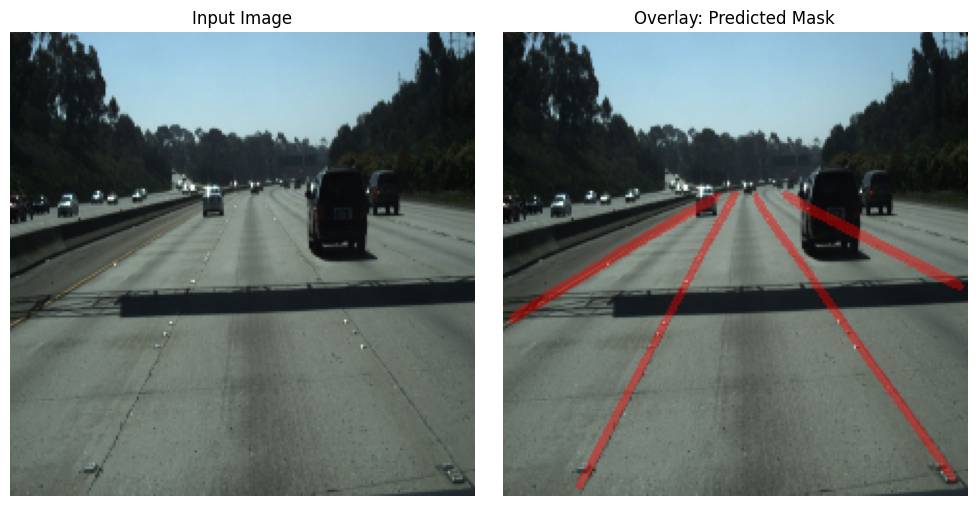

In [44]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=1, alpha=0.4)

### Alternative Test Dataset

In [45]:
import json
import pandas as pd
import os

# Path to TuSimple test JSON
json_path = "Z:/EE_297A/dataset/lanes/TuSimple/test_set/test_tasks_0627.json"

with open(json_path, "r") as f:
    data = [json.loads(line) for line in f]  # each line is a JSON object

# Convert to DataFrame for easy access
df = pd.DataFrame(data)
print(df.head(100))
len(df)

                                            h_samples lanes  run_time  \
0   [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
1   [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
2   [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
3   [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
4   [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
..                                                ...   ...       ...   
95  [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
96  [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
97  [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
98  [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   
99  [160, 170, 180, 190, 200, 210, 220, 230, 240, ...    []      1000   

                                   raw_file  
0   clips/0530/1492626760788443246_0/20.jpg  
1   clips/0530/1492627171538356

2782

In [46]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

def show_prediction_from_path(model, device, img_path, alpha=0.4, color=(1, 0, 0)):
    model.eval()

    # --- Load original image ---
    orig_img = cv2.imread(img_path)
    if orig_img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    H, W = orig_img.shape[:2]

    # --- Preprocess for model ---
    resized = cv2.resize(orig_img, (224, 224), interpolation=cv2.INTER_LINEAR)
    img_tensor = torch.from_numpy(resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(device)

    # --- Model inference ---
    with torch.no_grad():
        pred_mask = model(img_tensor)          # logits
        pred_mask = torch.sigmoid(pred_mask)   # probabilities
        pred_mask = (pred_mask > 0.5).float()  # binary mask

    # --- Convert to numpy + resize back to original size ---
    pred_np = pred_mask.squeeze().cpu().numpy()
    pred_np = cv2.resize(pred_np, (W, H), interpolation=cv2.INTER_NEAREST)

    # Normalize image for display
    img_disp = orig_img.astype(np.float32) / 255.0

    # --- Create color overlay ---
    overlay = np.zeros_like(img_disp)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # --- Blend overlay where mask=1 ---
    blended = img_disp.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



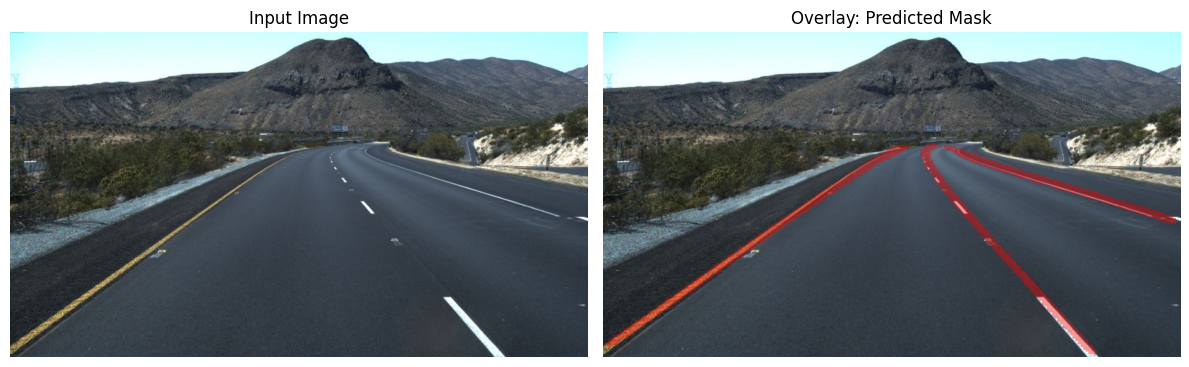

In [58]:
# Pick first raw_file from dataframe
img_path = os.path.join("Z:/EE_297A/dataset/lanes/TuSimple/test_set", df.iloc[857]["raw_file"])
show_prediction_from_path(model, device, img_path)

###### 

In [60]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import os

def show_prediction_from_path(model, device, img_path, alpha=0.4, color=(1, 0, 0)):
    model.eval()

    # --- Load original image ---
    orig_img = cv2.imread(img_path)
    if orig_img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # --- Flip image upside down ---
    flipped_img = cv2.flip(orig_img, 0)   # 0 → vertical flip

    H, W = flipped_img.shape[:2]

    # --- Preprocess for model ---
    resized = cv2.resize(flipped_img, (224, 224), interpolation=cv2.INTER_LINEAR)
    img_tensor = torch.from_numpy(resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(device)

    # --- Model inference ---
    with torch.no_grad():
        pred_mask = model(img_tensor)          # logits
        pred_mask = torch.sigmoid(pred_mask)   # probabilities
        pred_mask = (pred_mask > 0.5).float()  # binary mask

    # --- Convert to numpy + resize back to original size ---
    pred_np = pred_mask.squeeze().cpu().numpy()
    pred_np = cv2.resize(pred_np, (W, H), interpolation=cv2.INTER_NEAREST)

    # Normalize image for display
    img_disp = flipped_img.astype(np.float32) / 255.0

    # --- Create color overlay ---
    overlay = np.zeros_like(img_disp)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # --- Blend overlay where mask=1 ---
    blended = img_disp.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title("Input Image (Upside Down)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask (Upside Down)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


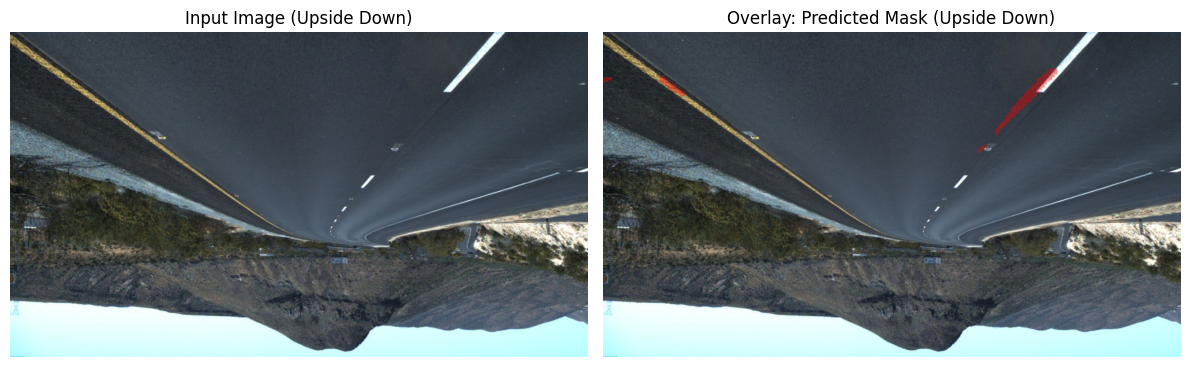

In [61]:
# Pick first raw_file from dataframe
img_path = os.path.join("Z:/EE_297A/dataset/lanes/TuSimple/test_set", df.iloc[857]["raw_file"])
show_prediction_from_path(model, device, img_path)
